In [19]:
import random
from shutil import copyfile

import os,sys
import zipfile
import shutil
from os import path, getcwd, chdir

## Bare minimum library requirement
import tensorflow as tf
import keras
#Keras provide API for Augmentation helps in generation
from tensorflow.keras.optimizers import RMSprop

# Making Folders for train and test 

In [20]:
# ! rm -rf /kaggle/working/*

In [21]:
! cp -R /kaggle/input/* /kaggle/working

In [22]:
#List down all directories in "/kaggle/input/"
for dirName,_,fileName in os.walk("/kaggle/input/microsoft-catsvsdogs-dataset"):
    print(dirName)

/kaggle/input/microsoft-catsvsdogs-dataset
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat


In [23]:
#List down all directories in "/kaggle/working/"
for dirName,_,fileName in os.walk("/kaggle/working/microsoft-catsvsdogs-dataset/"):
    count = 0
    print("Directory:: ",dirName)

Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog


In [24]:
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/

! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/

# Handling images

In [25]:
def split_data(source, training, testing, split_size=0.8):

    all_files = [i for i in os.listdir(source) if os.path.getsize(os.path.join(source, i)) > 0]


    random.shuffle(all_files)
    split_points = int(len(all_files) * split_size)

    train_files = all_files[:split_points]
    test_files = all_files[split_points:]

    for file in train_files:
        copyfile(os.path.join(source, file), os.path.join(training, file))

    for file in test_files:
        copyfile(os.path.join(source, file), os.path.join(testing, file))
    

In [26]:
CAT_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat/"
DOG_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog/"

TRAINING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/"
TESTING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/"

TRAINING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/"
TESTING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/"

In [27]:
split_size = 0.8
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [28]:
print("Total Cat iamge count :: ",len(os.listdir(TRAINING_CATS_DIR)))
print("Total Dog iamge count :: ",len(os.listdir(TRAINING_DOGS_DIR)))

Total Cat iamge count ::  10000
Total Dog iamge count ::  10000


# Show Images

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, subplots, show
CAT_TRAINING_DIR , DOG_TRAINING_DIR  =  TRAINING_CATS_DIR,TRAINING_DOGS_DIR

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

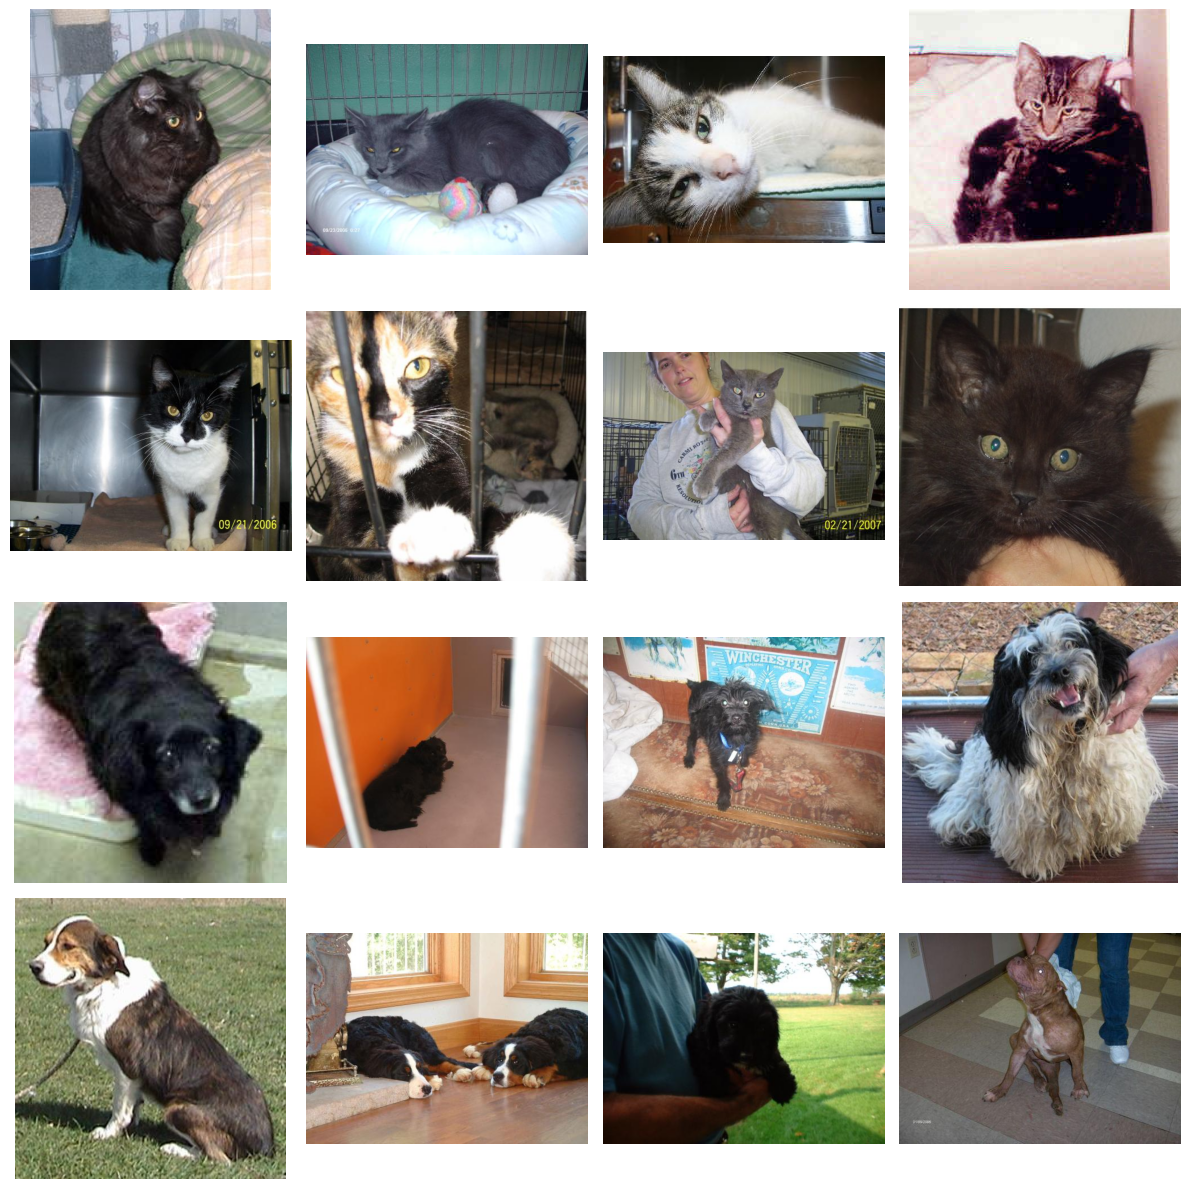

In [30]:
# This code displays 8 cat images and 8 dog images (total 16)
cat_imgs = os.listdir(CAT_TRAINING_DIR)[:8]
dog_imgs = os.listdir(DOG_TRAINING_DIR)[:8]

# It loads the image file names, combines them into one list
images = [os.path.join(CAT_TRAINING_DIR, img) for img in cat_imgs] + \
         [os.path.join(DOG_TRAINING_DIR, img) for img in dog_imgs]

# shows them without axes for a clean layout
plt.figure(figsize=(12, 12))

for i, img_path in enumerate(images):
    plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')  

plt.tight_layout()
plt.show()

# Data Augmentation

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot(data_generator):

    data_generator.fit(images)
    image_iterator = data_generator.flow(images)


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
    for ax in axes:
        ax.imshow(next(image_iterator)[0].astype('int'))
        ax.axis('on')
    plt.show()

In [32]:
def data_augmentation():

    data_generator = ImageDataGenerator(rotation_range=30)
    plot(data_generator)

    data_generator = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
    plot(data_generator)

    data_generator = ImageDataGenerator(horizontal_flip=True)
    plot(data_generator)

    data_generator = ImageDataGenerator(shear_range=15)
    plot(data_generator)

    data_generator = ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=0.2)
    plot(data_generator)

    data_generator = ImageDataGenerator(rescale=1./255)
    plot(data_generator)

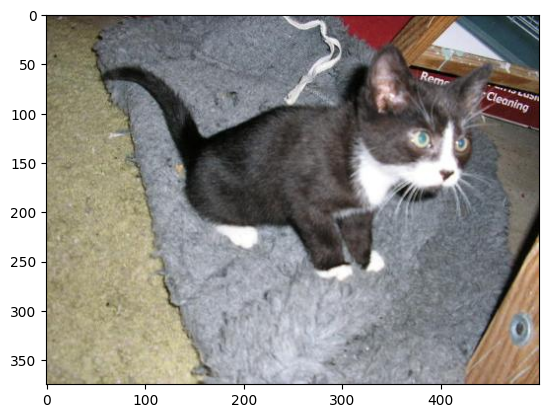

In [34]:
import os
import matplotlib.pyplot as plt

pic_index = 0

pic_index +=10

next_pic = [
    os.path.join(CAT_TRAINING_DIR, fname) for fname in os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/')[pic_index - 8:pic_index]
]
image = plt.imread(next_pic[0])
# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()

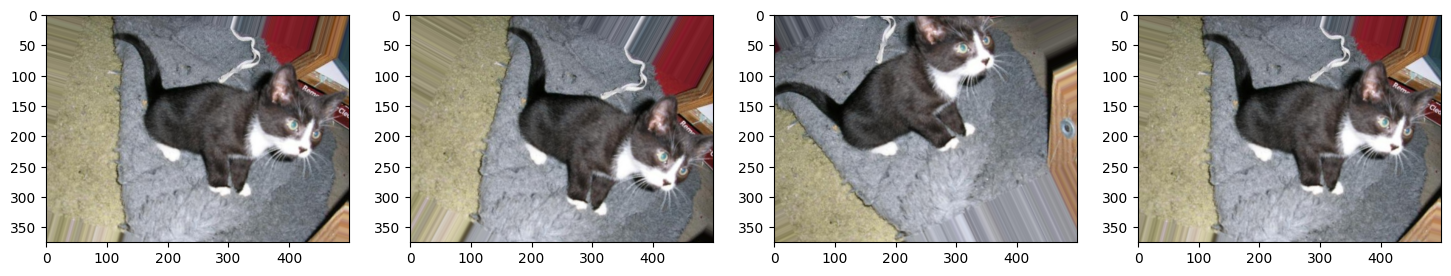

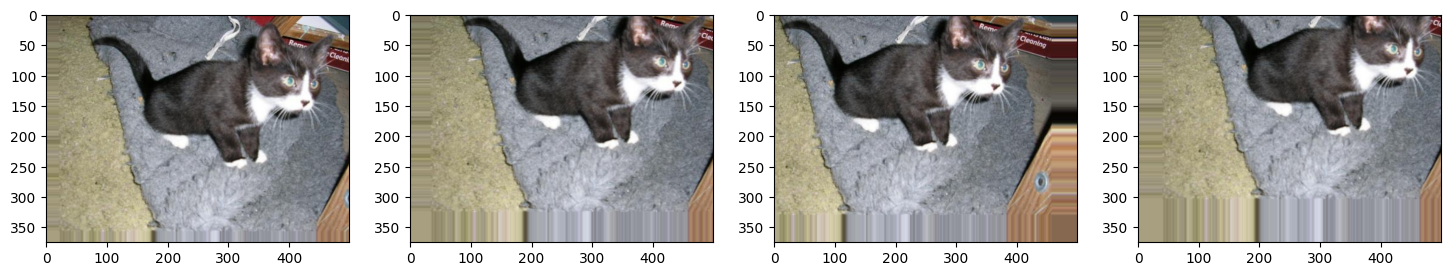

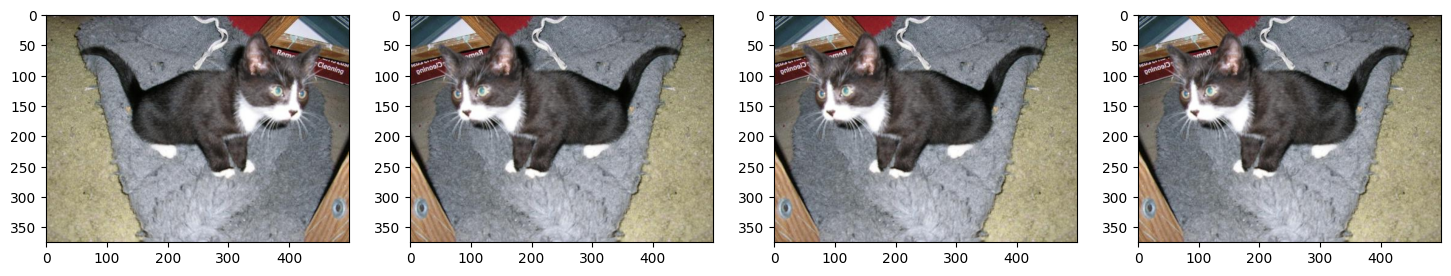

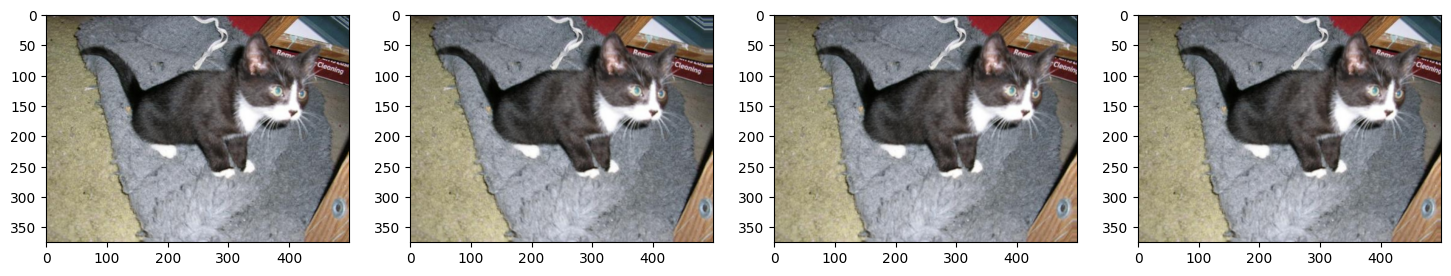

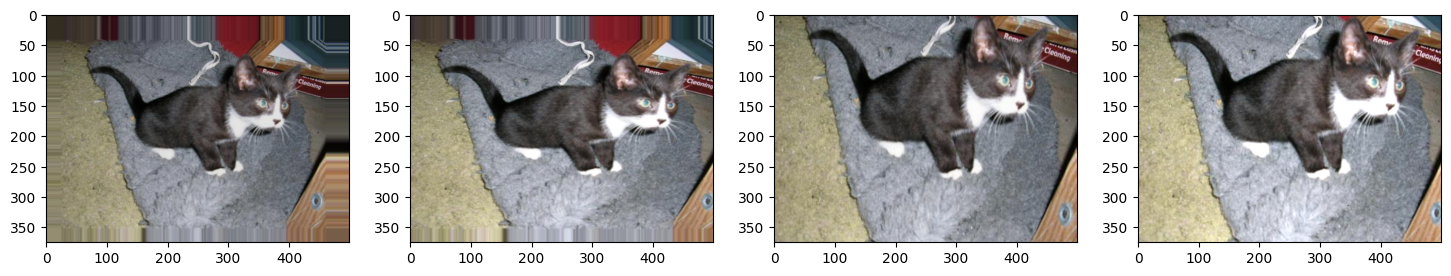

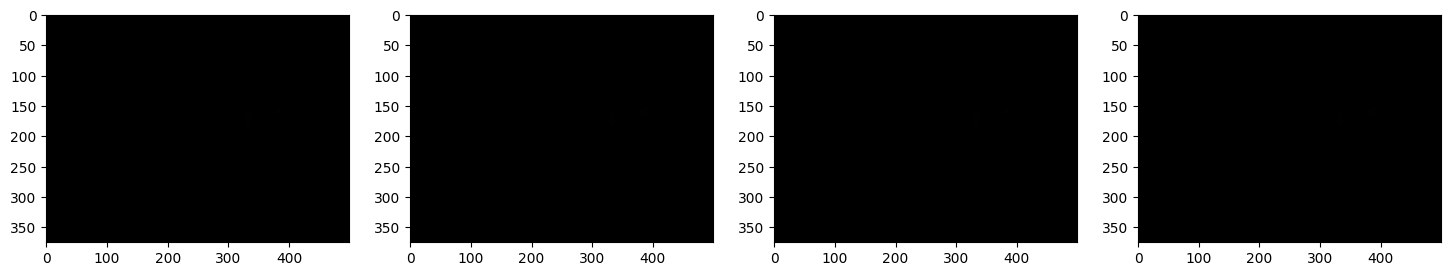

In [35]:
data_augmentation()

# Data Augmentation and NN Evaluation

In [36]:
train_dir = "/kaggle/working/microsoft-catsvsdogs-dataset/training/"        
val_dir   = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/"         


train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)

train_images = train_gen.flow_from_directory(train_dir, 
                                             target_size=(150, 150), 
                                             batch_size=50, 
                                             class_mode='binary')

test_images = val_gen.flow_from_directory(val_dir,
                                          target_size=(150, 150),
                                          batch_size=50,
                                          class_mode='binary')

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=7, restore_best_weights=True)

history = cnn_model.fit(
    train_images,
    validation_data=test_images,
    steps_per_epoch=150,
    epochs=20,
    callbacks=[early_stop]
)

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.5351 - loss: 1.0137 - val_accuracy: 0.6114 - val_loss: 0.6403
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 403s 3s/step - accuracy: 0.6330 - loss: 0.6223 - val_accuracy: 0.6338 - val_loss: 0.6259
Epoch 3/20
100/150 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.7061 - loss: 0.5649

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7065 - loss: 0.5627 - val_accuracy: 0.7260 - val_loss: 0.5538
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.7461 - loss: 0.5232 - val_accuracy: 0.7444 - val_loss: 0.5193
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.7456 - loss: 0.5102 - val_accuracy: 0.7796 - val_loss: 0.4604
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7915 - loss: 0.4469 - val_accuracy: 0.7954 - val_loss: 0.4499
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.8133 - loss: 0.4063 - val_accuracy: 0.7930 - val_loss: 0.4440
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8312 - loss: 0.3837 - val_accuracy: 0.8074 - val_loss: 0.4442
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.8420 - loss: 0.3614 - val_accuracy: 0.7710 - val_loss: 0.4800
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8502 - loss: 0.3481 - val_accuracy: 0.79

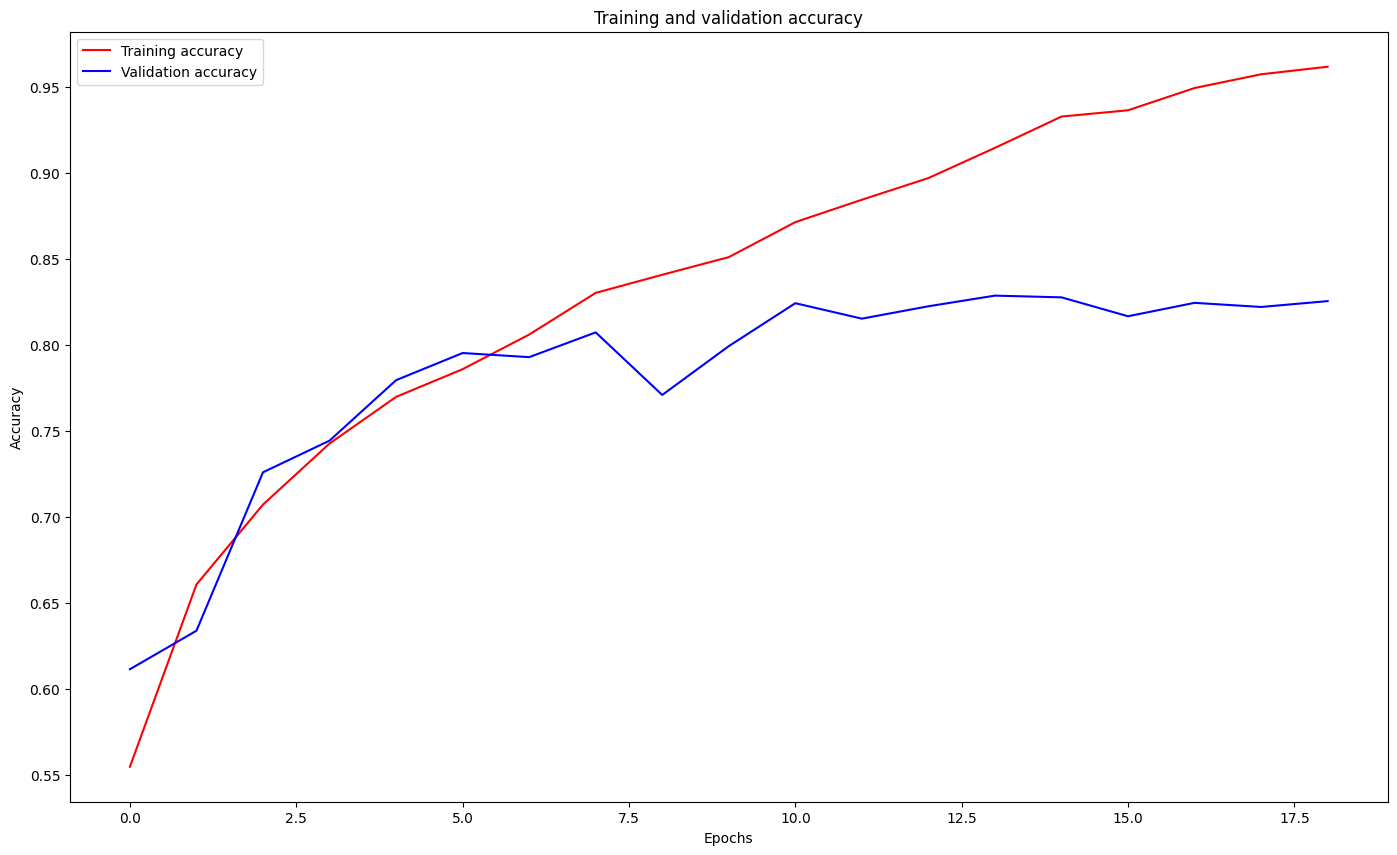

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize=(17, 10))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()

# nice accuracy and we will show prediction

100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 568ms/step


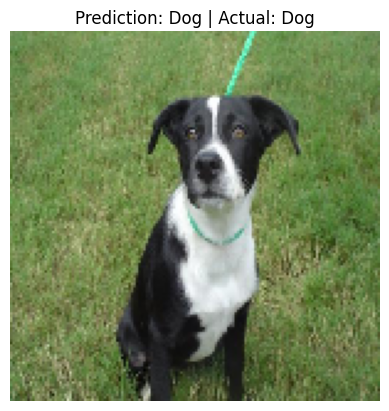

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random


predictions = cnn_model.predict(test_images)
pred_labels = (predictions > 0.5).astype(int).flatten()


class_names = list(test_images.class_indices.keys())


def show_random_prediction(generator, pred_labels, class_names):
    
    batch_index = random.randint(0, len(generator) - 1)
    image_batch, label_batch = generator[batch_index]
    
    
    img = image_batch[0]
    true_label = int(label_batch[0])
    pred_label = int(pred_labels[batch_index * generator.batch_size])  

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_names[pred_label]} | Actual: {class_names[true_label]}")
    plt.show()


show_random_prediction(test_images, pred_labels, class_names)
